In [11]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score, fbeta_score
from sklearn.metrics import  confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.base import clone


### Import data

In [12]:
# Upload the data file
df = pd.read_csv("df_cleaned.csv")

# Remove homes with unknown service line material
df = df[df["System-Owned Portion Service Line Material Classification "] != "MU"]

# Create binary classification for lead or non-lead pipes
df["is_lead"] = (df["System-Owned Portion Service Line Material Classification "]=="PB").astype(int)


/var/folders/68/w_2pz71n3c54dvg5_3838cxw0000gn/T/ipykernel_39741/2866953545.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("df_cleaned.csv")


### Some preliminary visualization

In [13]:
df.columns 

Index(['Unnamed: 0', 'PARCEL ID', 'YEARBLT', 'Street Number', 'Street Name',
       'City', 'Zip Code', 'County', 'Latitude', 'Longitude',
       'System-Owned Portion Service Line Material Classification ', 'is_lead',
       'is_lead_pm', 'nn_is_lead', 'nn_distance_km', 'nn_is_lead_weighted'],
      dtype='object')

In [29]:
from sklearn.preprocessing import LabelEncoder

df_corr = df[['Latitude', 'Longitude', 'YEARBLT', 'Zip Code', 'County', 'is_lead']].copy()


# Encode large categoricals like Zip Code and County numerically just to get rough correlation
df_corr['Zip Code'] = LabelEncoder().fit_transform(df_corr['Zip Code'].astype(str))
df_corr['County'] = LabelEncoder().fit_transform(df_corr['County'].astype(str))

feature_corr = df_corr.corr()['is_lead'].drop('is_lead')
print(" Feature Correlation with Lead Presence:\n")
print(feature_corr.reindex(feature_corr.abs().sort_values(ascending=False).head(10).index))

 Feature Correlation with Lead Presence:

YEARBLT     -0.447853
Latitude    -0.072932
County       0.005956
Zip Code    -0.000306
Longitude   -0.000046
Name: is_lead, dtype: float64


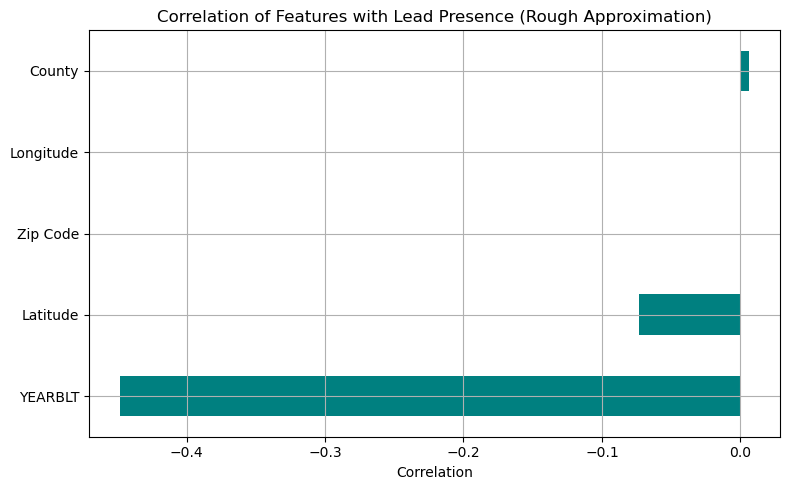

In [30]:

plt.figure(figsize=(8, 5))
feature_corr.sort_values().plot(kind='barh', color='teal')
plt.title('Correlation of Features with Lead Presence (Rough Approximation)')
plt.xlabel('Correlation')
plt.tight_layout()
plt.grid(True)
plt.show()

<Axes: xlabel='is_lead', ylabel='YEARBLT'>

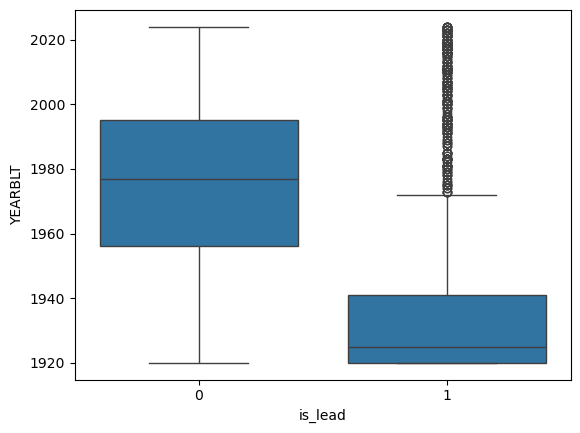

In [16]:
# Visualization: Year built corerlation with is_lead
sns.boxplot(x='is_lead', y='YEARBLT', data=df)


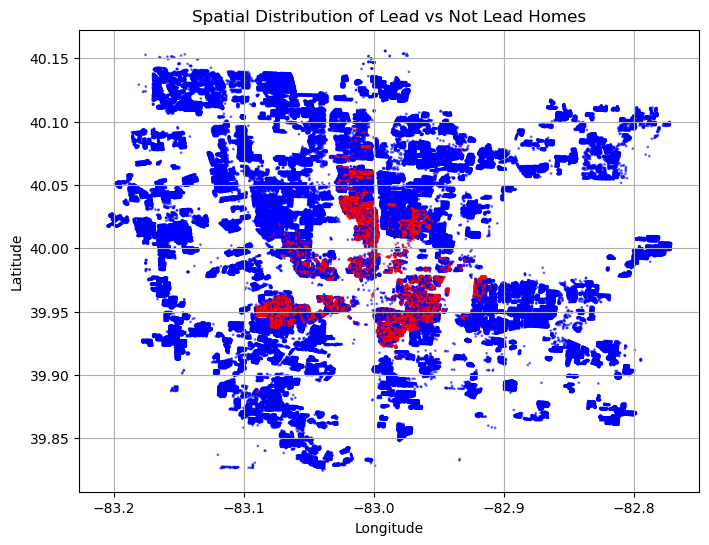

In [17]:
# Visualization: Distribution of service line material
plt.figure(figsize=(8, 6))
colors = df['is_lead'].map({1: 'red', 0: 'blue'})
plt.scatter(df['Longitude'], df['Latitude'], c=colors, alpha=0.5, marker='o', s=1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Distribution of Lead vs Not Lead Homes')
plt.grid(True)
plt.show()


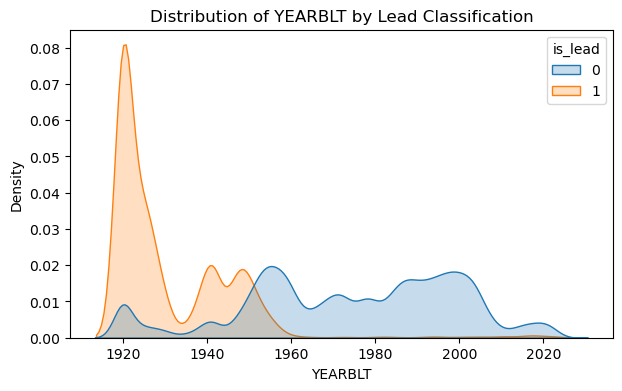

In [18]:
for col in ['YEARBLT']:
    plt.figure(figsize=(7, 4))
    sns.kdeplot(data=df, x=col, hue='is_lead', fill=True, common_norm=False)
    plt.title(f'Distribution of {col} by Lead Classification')
    plt.show()

### KNN Models

In [6]:
X = df[['Latitude', 'Longitude', 'YEARBLT']]
y = df['is_lead']

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [7]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), ['Latitude', 'Longitude', 'YEARBLT'])
])

base_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=8, weights='distance'))
])

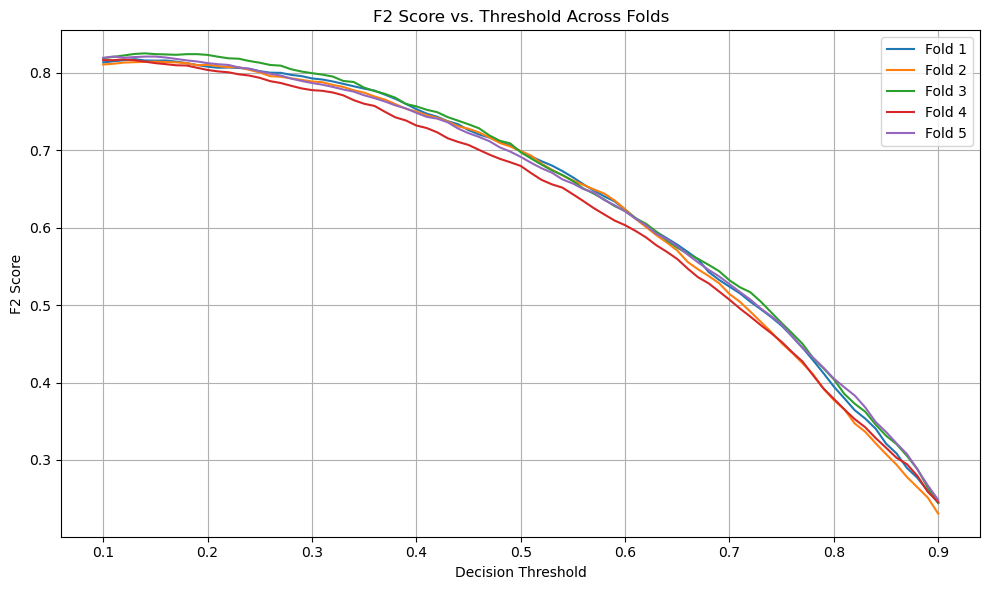

In [19]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
thresholds = np.linspace(0.1, 0.9, 81)
best_thresholds = []
f2_scores = []

plt.figure(figsize=(10, 6))
for i, (train_idx, val_idx) in enumerate(skf.split(X_train_full, y_train_full)):
    X_train_fold, X_val_fold = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]
    y_train_fold, y_val_fold = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]

    pipeline = clone(base_pipeline)
    pipeline.fit(X_train_fold, y_train_fold)

    probas = pipeline.predict_proba(X_val_fold)[:, 1]
    fold_f2_scores = [fbeta_score(y_val_fold, probas >= t, beta=2) for t in thresholds]
    best_idx = np.argmax(fold_f2_scores)

    best_thresholds.append(thresholds[best_idx])
    f2_scores.append(fold_f2_scores[best_idx])

    plt.plot(thresholds, fold_f2_scores, label=f'Fold {i+1}')

plt.xlabel("Decision Threshold")
plt.ylabel("F2 Score")
plt.title("F2 Score vs. Threshold Across Folds")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
optimal_threshold = np.mean(best_thresholds)
print(f"\nOptimal average threshold across folds: {optimal_threshold:.3f}")
print(f"Mean F2 score across folds: {np.mean(f2_scores):.3f}")



Optimal average threshold across folds: 0.130
Mean F2 score across folds: 0.819


In [21]:
final_pipeline = clone(base_pipeline)
final_pipeline.fit(X_train_full, y_train_full)
test_probas = final_pipeline.predict_proba(X_test)[:, 1]
y_pred = (test_probas >= optimal_threshold).astype(int)

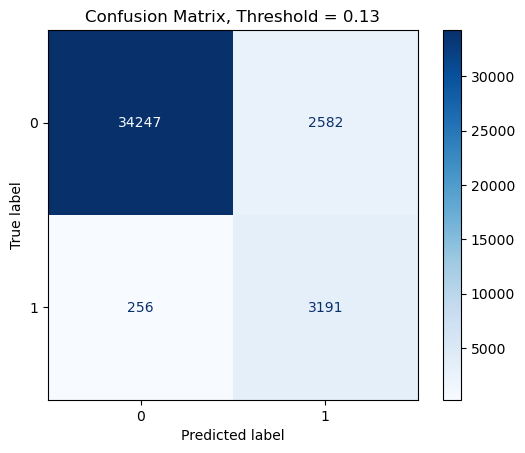

In [23]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title(f"Confusion Matrix, Threshold = {optimal_threshold}")
plt.show()

In [24]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f2 = fbeta_score(y_test, y_pred, beta=2)

print("\n--- Final Evaluation on Holdout Test Set ---")
print(f"Accuracy : {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall   : {recall:.3f}")
print(f"F2 Score : {f2:.3f}")


--- Final Evaluation on Holdout Test Set ---
Accuracy : 0.930
Precision: 0.553
Recall   : 0.926
F2 Score : 0.816


## Plots

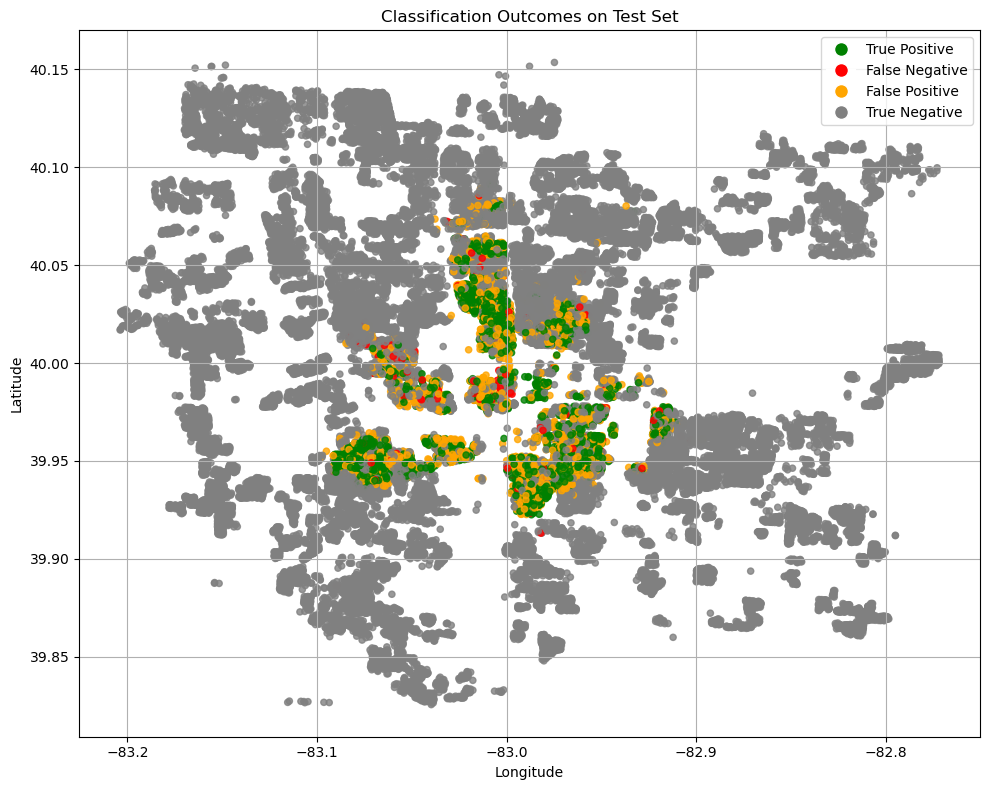

In [25]:

# Classification outcome map
lat = X_test['Latitude'].values
lon = X_test['Longitude'].values
outcome_color = []
for true, pred in zip(y_test, y_pred):
    if true == 1 and pred == 1:
        outcome_color.append('green')
    elif true == 1 and pred == 0:
        outcome_color.append('red')
    elif true == 0 and pred == 1:
        outcome_color.append('orange')
    else:
        outcome_color.append('gray')

plt.figure(figsize=(10, 8))
plt.scatter(lon, lat, c=outcome_color, s=20, alpha=0.8)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Classification Outcomes on Test Set")
legend_patches = [
    plt.Line2D([0], [0], marker='o', color='w', label='True Positive', markerfacecolor='green', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='False Negative', markerfacecolor='red', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='False Positive', markerfacecolor='orange', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='True Negative', markerfacecolor='gray', markersize=10),
]
plt.legend(handles=legend_patches, loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


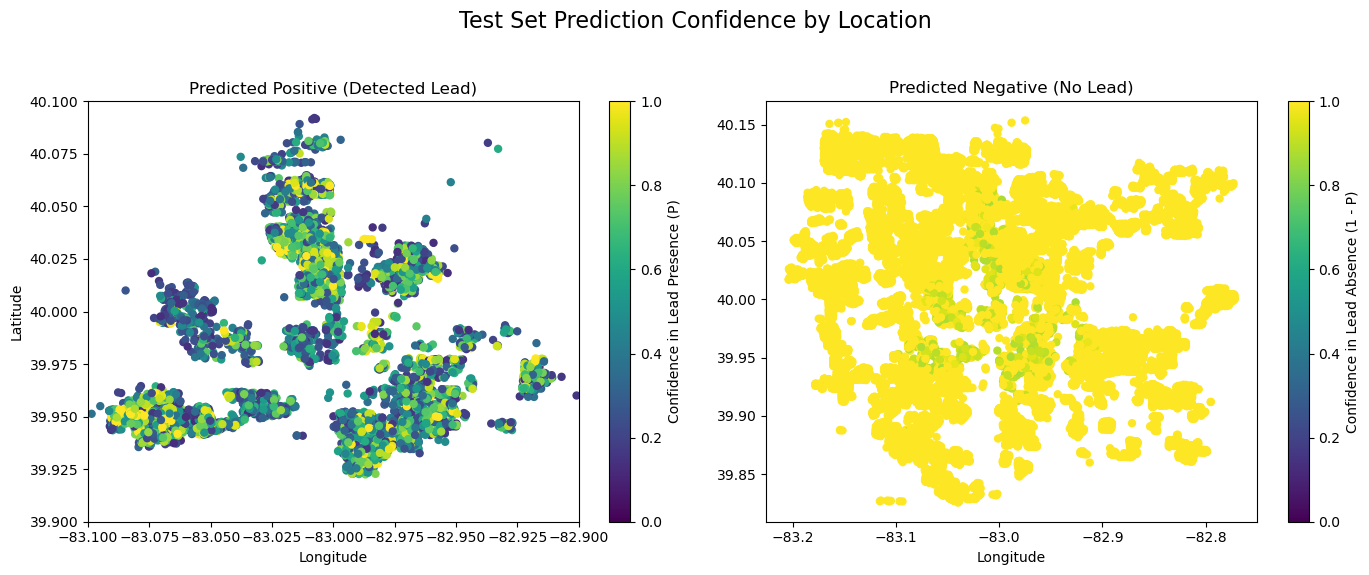

In [27]:
# Confidence plots
positive_mask = y_pred == 1
negative_mask = y_pred == 0

fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharex=False, sharey=False)

sc1 = axs[0].scatter(
    lon[positive_mask], lat[positive_mask],
    c=test_probas[positive_mask], cmap='viridis', vmin=0, vmax=1, s=25
)
axs[0].set_title('Predicted Positive (Detected Lead)')
axs[0].set_xlabel("Longitude")
axs[0].set_ylabel("Latitude")
axs[0].set_xlim(-83.1, -82.9)
axs[0].set_ylim(39.9, 40.1)
cbar1 = plt.colorbar(sc1, ax=axs[0])
cbar1.set_label("Confidence in Lead Presence (P)")

sc2 = axs[1].scatter(
    lon[negative_mask], lat[negative_mask],
    c=1 - test_probas[negative_mask], cmap='viridis', vmin=0, vmax=1, s=25
)
axs[1].set_title('Predicted Negative (No Lead)')
axs[1].set_xlabel("Longitude")
cbar2 = plt.colorbar(sc2, ax=axs[1])
cbar2.set_label("Confidence in Lead Absence (1 - P)")

plt.suptitle("Test Set Prediction Confidence by Location", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
